In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
import group_lasso

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
holidays_events["holiday_type"] = holidays_events["type"]
holidays_events.drop(["type"],axis=1,inplace=True)
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
oil2 = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1")
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

C:\Users\ndzad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [126]:
len(holidays_events["holiday_type"].unique())

6

In [115]:
a

In [129]:
np.repeat([1,2,3,4,5,6,7,8,9,10],[7,12,3,54,22,16,5,17,24,6])

array([ 1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10])

In [ ]:
["dayofweek"=7,"month"=12,"locale"=3,"store_nbr"=54,"city"=22, "state"=16, "type"=5, "cluster"=17,"locale_name"=24, "holiday_type"=6]

In [5]:
def przygotowanie_danych_rodzinnych(df, family):
    #Łaczymy z pozostałymi zbiorami
    df = df.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])
    df = df.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])
    df = df.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])
    #Wybieramy family ze zbioru traningowego
    df_fam = df.loc[(df['family']==family)]
    #Średnia po sales
    #df_fam.groupby(['date'])['sales'].mean().to_frame()

    df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
    df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month
    #df_fam['year'] = pd.to_datetime(df_fam['date']).dt.year
    #One Hot Encoding
    final_df_fam = pd.get_dummies(df_fam,columns=["dayofweek","month","locale","store_nbr","city", "state", "type", "cluster","locale_name", "holiday_type"],prefix=["dayofweek","month","locale","store_nbr","city", "state", "type", "cluster","locale_name", "holiday_type"])
    

    #Dodanie oil
    df_fam_oil = final_df_fam.merge(oil2,how="left",left_on=['date'],right_on=['date'])
    #Interpolacja braków
    df_fam_oil.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    df_fam_oil.drop(["description","transferred"],axis=1,inplace=True)
    return(df_fam_oil)

In [6]:
def przygotowanie_danych_sklepowych(df, store_nbr):
    #Łaczymy z pozostałymi zbiorami
    df = df.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])
    df = df.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])
    df = df.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])
    #Wybieramy store_nbr ze zbioru traningowego
    df_fam = df.loc[(df['store_nbr']==store_nbr)]
    #Średnia po sales
    #df_fam.groupby(['date'])['sales'].mean().to_frame()

    df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
    df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month
    #df_fam['year'] = pd.to_datetime(df_fam['date']).dt.year
    #One Hot Encoding
    final_df_fam = pd.get_dummies(df_fam,columns=["dayofweek","month","locale","family","city", "state", "type", "cluster","locale_name", "holiday_type"],prefix=["dayofweek","month","locale","family","city", "state", "type", "cluster","locale_name", "holiday_type"])
    
    #Dodanie oil
    df_fam_oil = final_df_fam.merge(oil2,how="left",left_on=['date'],right_on=['date'])
    #Interpolacja braków
    df_fam_oil.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    df_fam_oil.drop(["description","transferred"],axis=1,inplace=True)
    return(df_fam_oil)

In [7]:
def podzial(df, date):
    train = df.loc[(df['date']<date)].drop(["date"],axis=1)
    test = df.loc[(df['date']>=date)].reset_index(drop=True).drop(["date"],axis=1)
    return(train,test)

In [147]:
def predykcja_sklep(df1,df2,type):
    df3 = df1.drop([type],axis=1).copy()
    df4 = df2.drop([type],axis=1).copy()
    X = df3.drop(['sales'],axis=1)
    Y = df3['sales']
    #print(X.head())
    #print(Y.head())
    df4_drop = df4.drop(['sales'],axis=1)
    model = xgb.XGBRFRegressor().fit(X,Y)
    Y_pred = model.predict(df4_drop)
    Y_df4 = df4['sales']
    print(mean_squared_error(Y_df4,Y_pred)/(max(Y_df4)-min(Y_df4)))
    return(model)

In [37]:
def predykcja_sklep_OLS(df1,df2,type):
    df3 = df1.drop([type],axis=1).copy()
    df4 = df2.drop([type],axis=1).copy()
    X = df3.drop(['sales'],axis=1)
    Y = df3['sales']
    #print(X.head())
    #print(Y.head())
    df4_drop = df4.drop(['sales'],axis=1)
    model = sm.OLS(Y,X).fit()
    Y_pred = model.predict(df4_drop)
    Y_df4 = df4['sales']
    print(mean_squared_error(Y_df4,Y_pred)/np.mean(Y_df4))

    return(model)

In [149]:
(train2,test2) = podzial(przygotowanie_danych_rodzinnych(train,'AUTOMOTIVE'),'2016-06-01')

C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/1555495844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/1555495844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month


In [11]:
(train3,test3) = podzial(przygotowanie_danych_sklepowych(train,1),'2016-06-01')

C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/2542903860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/2542903860.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month


In [150]:
model_xgb = predykcja_sklep(train2,test2,'family')

0.15137815052345463


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

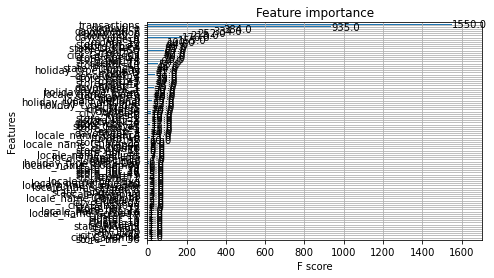

In [13]:
xgb.plot_importance(model_xgb)

In [14]:
model_ols = predykcja_sklep_OLS(train2,test2,'family')

22.48598869214968


In [15]:
test

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


In [16]:
test_t2 = przygotowanie_danych_rodzinnych(test,"AUTOMOTIVE")

C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/1555495844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_25152/1555495844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month


In [77]:
    train_t = train.copy()
    train_t = train_t.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])
    train_t = train_t.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])
    train_t = train_t.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])
    train_t.drop(["description","transferred"],axis=1,inplace=True)

In [78]:
[train_t, test_t] = podzial(train_t, '2016-06-01')

In [79]:
train_t

,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,locale,locale_name,holiday_type
0,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,D,13,NaN,National,Ecuador,Holiday
1,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13,NaN,National,Ecuador,Holiday
2,1,BEAUTY,0.000000,0,Quito,Pichincha,D,13,NaN,National,Ecuador,Holiday
3,1,BEVERAGES,0.000000,0,Quito,Pichincha,D,13,NaN,National,Ecuador,Holiday
4,1,BOOKS,0.000000,0,Quito,Pichincha,D,13,NaN,National,Ecuador,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
2252443,9,POULTRY,493.638980,0,Quito,Pichincha,B,6,2217.0,NaN,NaN,NaN
2252444,9,PREPARED FOODS,89.048996,1,Quito,Pichincha,B,6,2217.0,NaN,NaN,NaN
2252445,9,PRODUCE,2367.612000,138,Quito,Pichincha,B,6,2217.0,NaN,NaN,NaN
2252446,9,SCHOOL AND OFFICE SUPPLIES,4.000000,0,Quito,Pichincha,B,6,2217.0,NaN,NaN,NaN


In [90]:
X_tree = train_t.drop(["sales"],axis=1)
Y_tree = train_t["sales"]

In [98]:
X_tree["family"], uniques=pd.factorize(X_tree["family"])
X_tree["city"], uniques=pd.factorize(X_tree["city"])
X_tree["state"], uniques=pd.factorize(X_tree["state"])
X_tree["type"], uniques=pd.factorize(X_tree["type"])
X_tree["locale"], uniques=pd.factorize(X_tree["locale"])
X_tree["locale_name"], uniques=pd.factorize(X_tree["locale_name"])
X_tree["holiday_type"], uniques=pd.factorize(X_tree["holiday_type"])
X_tree.fillna(0,inplace=True)

In [100]:
tree1 = DecisionTreeRegressor().fit(X_tree,Y_tree)

In [101]:
X_tree_test = test_t.drop(["sales"],axis=1)
Y_tree_test = test_t["sales"]
X_tree_test["family"], uniques=pd.factorize(X_tree_test["family"])
X_tree_test["city"], uniques=pd.factorize(X_tree_test["city"])
X_tree_test["state"], uniques=pd.factorize(X_tree_test["state"])
X_tree_test["type"], uniques=pd.factorize(X_tree_test["type"])
X_tree_test["locale"], uniques=pd.factorize(X_tree_test["locale"])
X_tree_test["locale_name"], uniques=pd.factorize(X_tree_test["locale_name"])
X_tree_test["holiday_type"], uniques=pd.factorize(X_tree_test["holiday_type"])
X_tree_test.fillna(0,inplace=True)

Group lasso

In [133]:
X_gl = train2.drop(["family"],axis=1)
Y_gl = train2["sales"]

In [134]:
group_lasso.GroupLasso(groups=[ -1,-1,-1, 1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,-1]).fit(X_gl,Y_gl)

C:\Users\ndzad\anaconda3\lib\site-packages\group_lasso\_group_lasso.py:457: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
C:\Users\ndzad\anaconda3\lib\site-packages\group_lasso\_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


GroupLasso(groups=[-1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, ...])

In [142]:
train2

,family,sales,onpromotion,transactions,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,...,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,dcoilwtico
0,AUTOMOTIVE,0.0,0,770.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,93.14
1,AUTOMOTIVE,0.0,0,770.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,93.14
2,AUTOMOTIVE,0.0,0,770.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,93.14
3,AUTOMOTIVE,0.0,0,770.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,93.14
4,AUTOMOTIVE,0.0,0,770.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,93.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,AUTOMOTIVE,8.0,4,1004.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49.10
68252,AUTOMOTIVE,4.0,0,1898.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49.10
68253,AUTOMOTIVE,9.0,0,1728.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49.10
68254,AUTOMOTIVE,5.0,0,2712.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49.10


In [143]:
def predykcja_Group_Lasso(df1,df2,type):
    df3 = df1.drop([type],axis=1).copy()
    df4 = df2.drop([type],axis=1).copy()
    X = df3.drop(['sales'],axis=1)
    Y = df3['sales']
    #print(X.head())
    #print(Y.head())
    df4_drop = df4.drop(['sales'],axis=1)
    model = group_lasso.GroupLasso(groups=[-1,-1, 1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,-1]).fit(X,Y)
    Y_pred = model.predict(df4_drop)
    Y_df4 = df4['sales']
    print(mean_squared_error(Y_df4,Y_pred)/np.mean(Y_df4))

    return(model)

In [144]:
mod_gl = predykcja_Group_Lasso(train2,test2,"family")

C:\Users\ndzad\anaconda3\lib\site-packages\group_lasso\_group_lasso.py:457: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)


10.34591680846802


C:\Users\ndzad\anaconda3\lib\site-packages\group_lasso\_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


In [146]:
mod_gl.chosen_groups_

{-1, 7}

-Outliery
-Grupowanie po family,typie sklep (uśrednienie sprzedaży po dacie)
-